# Zonal Statistics - categorical values

In [1]:
import os
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterstats
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go

print('All libraries successfully imported!')
print(f'Rasterstats : {rasterstats.__version__}')

Rasterio : 1.0.8
Rasterstats : 0.14.0


## Set parameters

In [9]:
nodata_val = -10000

## Set directory (TP)

In [17]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_letter    = 'X'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_letter}/WORK/'

# Raster file
raster_file = f'{work_path}CLASSIF_OLD/Classif_RF_with_NDVI.tif'

# Vector file
vector_file  = f'{work_path}ROI/extent_roi_32631.shp'
vector_field = 'name'

# Look-up-table file
lut_file   = f'{work_path}LUT/LUT.xlsx'
code_field = 'CODE'
name_field = 'LC'  

# Zonal statistics output
zonal_stat_path = f'{work_path}ZONAL_STATS/'
zonal_stat_csv  = f'{zonal_stat_path}zonal_stat_cat.csv'

Path(zonal_stat_path).mkdir(parents=True, exist_ok=True)

## Set directory (Sen4Stat)

In [11]:
computer_path = '/export/projects/Sen4Stat/'

# Directory for all work files
work_path = f'{computer_path}WORK/'

# Raster file
raster_file = f'{work_path}CLASSIF/SITE_41/06-01_11-15/distMax_0/RF_OpenCV/SAMPLING_DESIGN_V25/SEN_2021_SITE_41_buf_0_LC_all_EXTENT_wall_to_wall_SEG_RATIO_100_LEVEL_grp_1_SD_25_FEAT_2_CLASSIF_RF_OpenCV_v1_reclassify_grp_A_nb.tif'

# Vector file
vector_file  = f'{work_path}SITE_EXTENT/SITE_41/SITE_41_ALL_4326.shp'
vector_field = 'NAME_2'

# Look-up-table file
lut_file   = f'{work_path}LUT/crop_dictionary_new.xlsx'
code_field = 'grp_A_nb'
name_field = 'grp_A'  

# Zonal statistics output
zonal_stat_path = f'{work_path}ZONAL_STATS/'
zonal_stat_csv  = f'{zonal_stat_path}zonal_stat_grp_A_feat_2.csv'

## Check if raster and vector are projected to the same CRS

In [12]:
gdf = gpd.read_file(vector_file)
src = rasterio.open(raster_file, "r")

crs_vector = str(gdf.crs).split(":",1)[1]
crs_raster = str(src.crs).split(":",1)[1]

if crs_vector == crs_raster:
    print(f'CRS are the same : EPSG:{crs_vector} = EPSG:{crs_raster}')
else:
    print('We must reproject vector file')

    gdf = gdf.to_crs(epsg=crs_raster)

We must reproject vector file


**Check if raster and vector file are intersecting**

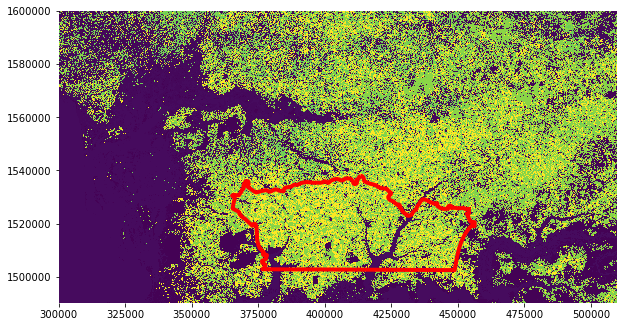

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot vector
gdf.plot(facecolor='none', edgecolor='red', linewidth = 4, ax=ax)

# Plot image
rasterio.plot.show(src, ax=ax)

plt.box(False)

## Build category map

rasterstats will report using the pixel values as keys. To associate the pixel values with their appropriate meaning, you can use a `category_map`

In [14]:
if os.path.isfile(lut_file):

    lut_df = pd.read_excel(lut_file)

    lut_df = lut_df[[code_field,name_field]].drop_duplicates()

    cmap = {}

    for index, row in lut_df.iterrows():

        nb   = row[code_field]
        name = row[name_field]

        cmap[nb] = f'{nb} - {name}'

else:
    cmap = None

print(cmap)

{0: '0 - Remove', 111: '111 - Wheat', 112: '112 - Maize', 113: '113 - Rice', 114: '114 - Sorghum', 115: '115 - Barley', 116: '116 - Rye', 117: '117 - Oats', 118: '118 - Millets', 119: '119 - Other cereals', 121: '121 - Leafy or stem vegetables', 122: '122 - Fruit-bearing vegetables', 123: '123 - Root, bulb or tuberous vegetables', 124: '124 - Mushrooms and truffles', 141: '141 - Soya beans', 142: '142 - Groundnuts', 143: '143 - Other oilseed crops', 151: '151 - Potatoes', 152: '152 - Sweet potatoes', 153: '153 - Cassava', 154: '154 - Yams', 161: '161 - Spice crops', 162: '162 - Hops', 17: '17 - Leguminous crops', 181: '181 - Sugar beet', 182: '182 - Sugar cane', 3: '3 - Grassland and meadows', 192: '192 - Fibre crops', 1931: '1931 - Medicinal, aromatic, pesticidal or similar crops', 1941: '1941 - Flowers crops', 1991: '1991 - Tobacco', 21: '21 - Fruits trees', 22: '22 - Vineyards', 23: '23 - Olive groves', 24: '24 - Trees', 291: '291 - Succulent plant', 5: '5 - Shrub land', 6: '6 - For

## Compute zonal statistics with rasterstats

In [15]:
dict_list = []

for i, row in gdf.iterrows():

    name  = row[vector_field]
    
    dict_freq = zonal_stats(row.geometry,
                            raster_file,
                            categorical=True,
                            category_map=cmap,
                            nodata=nodata_val)[0]

    dict_freq['name'] = name

    dict_list.append(dict_freq)

df = pd.DataFrame(dict_list).set_index('name')

df.to_csv(zonal_stat_csv)

print(f'CSV file was created : {zonal_stat_csv}')

df = df.transpose()
df = df.sort_values(by=df.columns[0], ascending=False)
display(df)

CSV file was created : /export/projects/Sen4Stat/WORK/ZONAL_STATS/zonal_stat_grp_A_feat_2.csv


name,Nioro du Rip
118 - Millets,9690532
142 - Groundnuts,8034428
112 - Maize,1412928
6 - Forest,1397265
5 - Shrub land,875362
8 - Build-up surface,866193
9 - Water bodies,830691
7 - Bare soil,136304


In [22]:
df['percent'] = ((df.iloc[:,0]/ df.iloc[:,0].sum())*100).round(2)

display(df)

name,Nioro du Rip,percent
118 - Millets,9690532,41.69
142 - Groundnuts,8034428,34.57
112 - Maize,1412928,6.08
6 - Forest,1397265,6.01
5 - Shrub land,875362,3.77
8 - Build-up surface,866193,3.73
9 - Water bodies,830691,3.57
7 - Bare soil,136304,0.59


## Plot histogram

In [23]:
fig = px.bar(df,
        x=df.index.str.slice(start=0, stop=20),
        y=df.columns[0],
        text='percent')

fig.show()